In [3]:

from __future__ import absolute_import
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop, Adagrad
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU
from keras.datasets import imdb

'''
    Train a LSTM on the IMDB sentiment classification task.
    The dataset is actually too small for LSTM to be of any advantage
    compared to simpler, much faster methods such as TF-IDF+LogReg.
    Notes:
    - RNNs are tricky. Choice of batch size is important,
    choice of loss and optimizer is critical, etc.
    Some configurations won't converge.
    - LSTM loss decrease patterns during training can be quite different
    from what you see with CNNs/MLPs/etc.
    GPU command:
        THEANO_FLAGS=mode=FAST_RUN,device=gpu,floatX=float32 python imdb_lstm.py
'''

max_features = 20000
maxlen = 100  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print("Loading data...")
(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=max_features, test_split=0.2)
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print("Pad sequences (samples x time)")
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, 128))  # try using a GRU instead, for fun
model.add(Dropout(0.5))
model.add(Dense(128, 1))
model.add(Activation('sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy', optimizer='adam', class_mode="binary")

print("Train...")
model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=4, validation_data=(X_test, y_test), show_accuracy=True)
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size, show_accuracy=True)
print('Test score:', score)
print('Test accuracy:', acc)

Loading data...
33218560/33213513 [==============================] - 734s   
20000 train sequences
5000 test sequences
Pad sequences (samples x time)
X_train shape: (20000L, 100L)
X_test shape: (5000L, 100L)
Build model...
Train...
Train on 20000 samples, validate on 5000 samples
Epoch 0
20000/20000 [==============================] - 389s - loss: 0.4851 - acc: 0.7706 - val_loss: 0.4039 - val_acc: 0.8222
Epoch 1
20000/20000 [==============================] - 382s - loss: 0.2723 - acc: 0.8907 - val_loss: 0.3760 - val_acc: 0.8320
Epoch 2
20000/20000 [==============================] - 528s - loss: 0.1746 - acc: 0.9366 - val_loss: 0.3890 - val_acc: 0.8316
Epoch 3
5000/5000 [==============================] - 28s    
Test score: 0.485364478692
Test accuracy: 0.838


In [76]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=max_features, test_split=0.2)

In [107]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleDeepRNN

mean, std = 0,15
X, Y = [], []
for i in range(300):
    seq = np.array(np.random.normal(mean, std, 20),dtype=int)
    
    label = np.random.randint(2)
    if label==0: seq *= -1

    X.append(sorted(seq))
    Y.append(label)

X_train, Y_train = X[:200], Y[:200]
X_test, Y_test = X[200:], Y[200:]
    
    
model = Sequential()
# model.add(Embedding(15, 5))
model.add(SimpleDeepRNN(20,5, activation='sigmoid', inner_activation='hard_sigmoid'))
# model.add(Dropout(0.5))
model.add(Dense(5, 2))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop')

model.fit(X_train, Y_train, batch_size=4, nb_epoch=4)
score = model.evaluate(X_test, Y_test, batch_size=4)

KeyboardInterrupt: 

In [99]:
X_train = []
Y_train = []
X_test, Y_test = [],[]

mean, std = 0,15
X, Y = [], []
for i in range(300):
    seq = np.random.normal(mean, std, 20)
    
    label = np.random.randint(2)
    if label==0: seq *= -1

    X.append(sorted(seq))
    Y.append(label)

X_train, Y_train = X[:200], Y[:200]
X_test, Y_test = X[200:], Y[200:]
    
model.fit(X_train, Y_train, batch_size=4, nb_epoch=4)
score = model.evaluate(X_test, Y_test, batch_size=4)

Epoch 0
TypeError while preparing batch.                         If using HDF5 input data, pass shuffle="batch".



TypeError: only integer arrays with one element can be converted to an index

`%matplotlib` prevents importing * from pylab and numpy
D:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:398: UserWarning: The parameter 'updates' of theano.function() expects an OrderedDict, got <type 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (theano.compat.python2x.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.


Populating the interactive namespace from numpy and matplotlib
Elapsed time: 109.829000


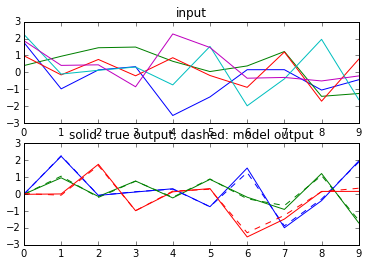

In [4]:
""" Vanilla RNN
@author Graham Taylor
"""
%pylab inline
import numpy as np
import theano
import theano.tensor as T
from sklearn.base import BaseEstimator
import logging
import time
import os
import datetime
import cPickle as pickle

logger = logging.getLogger(__name__)

import matplotlib.pyplot as plt
plt.ion()

mode = theano.Mode(linker='cvm')
#mode = 'DEBUG_MODE'


class RNN(object):
    """    Recurrent neural network class
    Supported output types:
    real : linear output units, use mean-squared error
    binary : binary output units, use cross-entropy error
    softmax : single softmax out, use cross-entropy error
    """
    def __init__(self, input, n_in, n_hidden, n_out, activation=T.tanh,
                 output_type='real', use_symbolic_softmax=False):

        self.input = input
        self.activation = activation
        self.output_type = output_type

        # when using HF, SoftmaxGrad.grad is not implemented
        # use a symbolic softmax which is slightly slower than T.nnet.softmax
        # See: http://groups.google.com/group/theano-dev/browse_thread/
        # thread/3930bd5a6a67d27a
        if use_symbolic_softmax:
            def symbolic_softmax(x):
                e = T.exp(x)
                return e / T.sum(e, axis=1).dimshuffle(0, 'x')
            self.softmax = symbolic_softmax
        else:
            self.softmax = T.nnet.softmax

        # recurrent weights as a shared variable
        W_init = np.asarray(np.random.uniform(size=(n_hidden, n_hidden),
                                              low=-.01, high=.01),
                                              dtype=theano.config.floatX)
        self.W = theano.shared(value=W_init, name='W')
        # input to hidden layer weights
        W_in_init = np.asarray(np.random.uniform(size=(n_in, n_hidden),
                                                 low=-.01, high=.01),
                                                 dtype=theano.config.floatX)
        self.W_in = theano.shared(value=W_in_init, name='W_in')

        # hidden to output layer weights
        W_out_init = np.asarray(np.random.uniform(size=(n_hidden, n_out),
                                                  low=-.01, high=.01),
                                                  dtype=theano.config.floatX)
        self.W_out = theano.shared(value=W_out_init, name='W_out')

        h0_init = np.zeros((n_hidden,), dtype=theano.config.floatX)
        self.h0 = theano.shared(value=h0_init, name='h0')

        bh_init = np.zeros((n_hidden,), dtype=theano.config.floatX)
        self.bh = theano.shared(value=bh_init, name='bh')

        by_init = np.zeros((n_out,), dtype=theano.config.floatX)
        self.by = theano.shared(value=by_init, name='by')

        self.params = [self.W, self.W_in, self.W_out, self.h0,
                       self.bh, self.by]

        # for every parameter, we maintain it's last update
        # the idea here is to use "momentum"
        # keep moving mostly in the same direction
        self.updates = {}
        for param in self.params:
            init = np.zeros(param.get_value(borrow=True).shape,
                            dtype=theano.config.floatX)
            self.updates[param] = theano.shared(init)

        # recurrent function (using tanh activation function) and linear output
        # activation function
        def step(x_t, h_tm1):
            h_t = self.activation(T.dot(x_t, self.W_in) + \
                                  T.dot(h_tm1, self.W) + self.bh)
            y_t = T.dot(h_t, self.W_out) + self.by
            return h_t, y_t

        # the hidden state `h` for the entire sequence, and the output for the
        # entire sequence `y` (first dimension is always time)
        [self.h, self.y_pred], _ = theano.scan(step,
                                               sequences=self.input,
                                               outputs_info=[self.h0, None])

        # L1 norm ; one regularization option is to enforce L1 norm to
        # be small
        self.L1 = 0
        self.L1 += abs(self.W.sum())
        self.L1 += abs(self.W_in.sum())
        self.L1 += abs(self.W_out.sum())

        # square of L2 norm ; one regularization option is to enforce
        # square of L2 norm to be small
        self.L2_sqr = 0
        self.L2_sqr += (self.W ** 2).sum()
        self.L2_sqr += (self.W_in ** 2).sum()
        self.L2_sqr += (self.W_out ** 2).sum()

        if self.output_type == 'real':
            self.loss = lambda y: self.mse(y)
        elif self.output_type == 'binary':
            # push through sigmoid
            self.p_y_given_x = T.nnet.sigmoid(self.y_pred)  # apply sigmoid
            self.y_out = T.round(self.p_y_given_x)  # round to {0,1}
            self.loss = lambda y: self.nll_binary(y)
        elif self.output_type == 'softmax':
            # push through softmax, computing vector of class-membership
            # probabilities in symbolic form
            self.p_y_given_x = self.softmax(self.y_pred)

            # compute prediction as class whose probability is maximal
            self.y_out = T.argmax(self.p_y_given_x, axis=-1)
            self.loss = lambda y: self.nll_multiclass(y)
        else:
            raise NotImplementedError

    def mse(self, y):
        # error between output and target
        return T.mean((self.y_pred - y) ** 2)

    def nll_binary(self, y):
        # negative log likelihood based on binary cross entropy error
        return T.mean(T.nnet.binary_crossentropy(self.p_y_given_x, y))

    def nll_multiclass(self, y):
        # negative log likelihood based on multiclass cross entropy error
        # y.shape[0] is (symbolically) the number of rows in y, i.e.,
        # number of time steps (call it T) in the sequence
        # T.arange(y.shape[0]) is a symbolic vector which will contain
        # [0,1,2,... n-1] T.log(self.p_y_given_x) is a matrix of
        # Log-Probabilities (call it LP) with one row per example and
        # one column per class LP[T.arange(y.shape[0]),y] is a vector
        # v containing [LP[0,y[0]], LP[1,y[1]], LP[2,y[2]], ...,
        # LP[n-1,y[n-1]]] and T.mean(LP[T.arange(y.shape[0]),y]) is
        # the mean (across minibatch examples) of the elements in v,
        # i.e., the mean log-likelihood across the minibatch.
        return -T.mean(T.log(self.p_y_given_x)[T.arange(y.shape[0]), y])

    def errors(self, y):
        """Return a float representing the number of errors in the sequence
        over the total number of examples in the sequence ; zero one
        loss over the size of the sequence
        :type y: theano.tensor.TensorType
        :param y: corresponds to a vector that gives for each example the
                  correct label
        """
        # check if y has same dimension of y_pred
        if y.ndim != self.y_out.ndim:
            raise TypeError('y should have the same shape as self.y_out',
                ('y', y.type, 'y_out', self.y_out.type))

        if self.output_type in ('binary', 'softmax'):
            # check if y is of the correct datatype
            if y.dtype.startswith('int'):
                # the T.neq operator returns a vector of 0s and 1s, where 1
                # represents a mistake in prediction
                return T.mean(T.neq(self.y_out, y))
            else:
                raise NotImplementedError()


class MetaRNN(BaseEstimator):
    def __init__(self, n_in=5, n_hidden=50, n_out=5, learning_rate=0.01,
                 n_epochs=100, L1_reg=0.00, L2_reg=0.00, learning_rate_decay=1,
                 activation='tanh', output_type='real',
                 final_momentum=0.9, initial_momentum=0.5,
                 momentum_switchover=5,
                 use_symbolic_softmax=False):
        self.n_in = int(n_in)
        self.n_hidden = int(n_hidden)
        self.n_out = int(n_out)
        self.learning_rate = float(learning_rate)
        self.learning_rate_decay = float(learning_rate_decay)
        self.n_epochs = int(n_epochs)
        self.L1_reg = float(L1_reg)
        self.L2_reg = float(L2_reg)
        self.activation = activation
        self.output_type = output_type
        self.initial_momentum = float(initial_momentum)
        self.final_momentum = float(final_momentum)
        self.momentum_switchover = int(momentum_switchover)
        self.use_symbolic_softmax = use_symbolic_softmax

        self.ready()

    def ready(self):
        # input (where first dimension is time)
        self.x = T.matrix()
        # target (where first dimension is time)
        if self.output_type == 'real':
            self.y = T.matrix(name='y', dtype=theano.config.floatX)
        elif self.output_type == 'binary':
            self.y = T.matrix(name='y', dtype='int32')
        elif self.output_type == 'softmax':  # only vector labels supported
            self.y = T.vector(name='y', dtype='int32')
        else:
            raise NotImplementedError
        # initial hidden state of the RNN
        self.h0 = T.vector()
        # learning rate
        self.lr = T.scalar()

        if self.activation == 'tanh':
            activation = T.tanh
        elif self.activation == 'sigmoid':
            activation = T.nnet.sigmoid
        elif self.activation == 'relu':
            activation = lambda x: x * (x > 0)
        elif self.activation == 'cappedrelu':
            activation = lambda x: T.minimum(x * (x > 0), 6)
        else:
            raise NotImplementedError

        self.rnn = RNN(input=self.x, n_in=self.n_in,
                       n_hidden=self.n_hidden, n_out=self.n_out,
                       activation=activation, output_type=self.output_type,
                       use_symbolic_softmax=self.use_symbolic_softmax)

        if self.output_type == 'real':
            self.predict = theano.function(inputs=[self.x, ],
                                           outputs=self.rnn.y_pred,
                                           mode=mode)
        elif self.output_type == 'binary':
            self.predict_proba = theano.function(inputs=[self.x, ],
                                outputs=self.rnn.p_y_given_x, mode=mode)
            self.predict = theano.function(inputs=[self.x, ],
                                outputs=T.round(self.rnn.p_y_given_x),
                                mode=mode)
        elif self.output_type == 'softmax':
            self.predict_proba = theano.function(inputs=[self.x, ],
                        outputs=self.rnn.p_y_given_x, mode=mode)
            self.predict = theano.function(inputs=[self.x, ],
                                outputs=self.rnn.y_out, mode=mode)
        else:
            raise NotImplementedError

    def shared_dataset(self, data_xy):
        """ Load the dataset into shared variables """

        data_x, data_y = data_xy
        shared_x = theano.shared(np.asarray(data_x,
                                            dtype=theano.config.floatX))

        shared_y = theano.shared(np.asarray(data_y,
                                            dtype=theano.config.floatX))

        if self.output_type in ('binary', 'softmax'):
            return shared_x, T.cast(shared_y, 'int32')
        else:
            return shared_x, shared_y

    def __getstate__(self):
        """ Return state sequence."""
        params = self._get_params()  # parameters set in constructor
        weights = [p.get_value() for p in self.rnn.params]
        state = (params, weights)
        return state

    def _set_weights(self, weights):
        """ Set fittable parameters from weights sequence.
        Parameters must be in the order defined by self.params:
            W, W_in, W_out, h0, bh, by
        """
        i = iter(weights)

        for param in self.rnn.params:
            param.set_value(i.next())

    def __setstate__(self, state):
        """ Set parameters from state sequence.
        Parameters must be in the order defined by self.params:
            W, W_in, W_out, h0, bh, by
        """
        params, weights = state
        self.set_params(**params)
        self.ready()
        self._set_weights(weights)

    def save(self, fpath='.', fname=None):
        """ Save a pickled representation of Model state. """
        fpathstart, fpathext = os.path.splitext(fpath)
        if fpathext == '.pkl':
            # User supplied an absolute path to a pickle file
            fpath, fname = os.path.split(fpath)

        elif fname is None:
            # Generate filename based on date
            date_obj = datetime.datetime.now()
            date_str = date_obj.strftime('%Y-%m-%d-%H:%M:%S')
            class_name = self.__class__.__name__
            fname = '%s.%s.pkl' % (class_name, date_str)

        fabspath = os.path.join(fpath, fname)

        logger.info("Saving to %s ..." % fabspath)
        file = open(fabspath, 'wb')
        state = self.__getstate__()
        pickle.dump(state, file, protocol=pickle.HIGHEST_PROTOCOL)
        file.close()

    def load(self, path):
        """ Load model parameters from path. """
        logger.info("Loading from %s ..." % path)
        file = open(path, 'rb')
        state = pickle.load(file)
        self.__setstate__(state)
        file.close()

    def fit(self, X_train, Y_train, X_test=None, Y_test=None,
            validation_frequency=100):
        """ Fit model
        Pass in X_test, Y_test to compute test error and report during
        training.
        X_train : ndarray (n_seq x n_steps x n_in)
        Y_train : ndarray (n_seq x n_steps x n_out)
        validation_frequency : int
            in terms of number of sequences (or number of weight updates)
        """
        if X_test is not None:
            assert(Y_test is not None)
            self.interactive = True
            test_set_x, test_set_y = self.shared_dataset((X_test, Y_test))
        else:
            self.interactive = False

        train_set_x, train_set_y = self.shared_dataset((X_train, Y_train))

        n_train = train_set_x.get_value(borrow=True).shape[0]
        if self.interactive:
            n_test = test_set_x.get_value(borrow=True).shape[0]

        ######################
        # BUILD ACTUAL MODEL #
        ######################
        logger.info('... building the model')

        index = T.lscalar('index')    # index to a case
        # learning rate (may change)
        l_r = T.scalar('l_r', dtype=theano.config.floatX)
        mom = T.scalar('mom', dtype=theano.config.floatX)  # momentum

        cost = self.rnn.loss(self.y) \
            + self.L1_reg * self.rnn.L1 \
            + self.L2_reg * self.rnn.L2_sqr

        compute_train_error = theano.function(inputs=[index, ],
                                              outputs=self.rnn.loss(self.y),
                                              givens={
                                                  self.x: train_set_x[index],
                                                  self.y: train_set_y[index]},
            mode=mode)

        if self.interactive:
            compute_test_error = theano.function(inputs=[index, ],
                        outputs=self.rnn.loss(self.y),
                        givens={
                            self.x: test_set_x[index],
                            self.y: test_set_y[index]},
                        mode=mode)

        # compute the gradient of cost with respect to theta = (W, W_in, W_out)
        # gradients on the weights using BPTT
        gparams = []
        for param in self.rnn.params:
            gparam = T.grad(cost, param)
            gparams.append(gparam)

        updates = {}
        for param, gparam in zip(self.rnn.params, gparams):
            weight_update = self.rnn.updates[param]
            upd = mom * weight_update - l_r * gparam
            updates[weight_update] = upd
            updates[param] = param + upd

        # compiling a Theano function `train_model` that returns the
        # cost, but in the same time updates the parameter of the
        # model based on the rules defined in `updates`
        train_model = theano.function(inputs=[index, l_r, mom],
                                      outputs=cost,
                                      updates=updates,
                                      givens={
                                          self.x: train_set_x[index],
                                          self.y: train_set_y[index]},
                                          mode=mode)

        ###############
        # TRAIN MODEL #
        ###############
        logger.info('... training')
        epoch = 0

        while (epoch < self.n_epochs):
            epoch = epoch + 1
            for idx in xrange(n_train):
                effective_momentum = self.final_momentum \
                               if epoch > self.momentum_switchover \
                               else self.initial_momentum
                example_cost = train_model(idx, self.learning_rate,
                                           effective_momentum)

                # iteration number (how many weight updates have we made?)
                # epoch is 1-based, index is 0 based
                iter = (epoch - 1) * n_train + idx + 1

                if iter % validation_frequency == 0:
                    # compute loss on training set
                    train_losses = [compute_train_error(i)
                                    for i in xrange(n_train)]
                    this_train_loss = np.mean(train_losses)

                    if self.interactive:
                        test_losses = [compute_test_error(i)
                                        for i in xrange(n_test)]
                        this_test_loss = np.mean(test_losses)

                        logger.info('epoch %i, seq %i/%i, tr loss %f '
                                    'te loss %f lr: %f' % \
                        (epoch, idx + 1, n_train,
                         this_train_loss, this_test_loss, self.learning_rate))
                    else:
                        logger.info('epoch %i, seq %i/%i, train loss %f '
                                    'lr: %f' % \
                                    (epoch, idx + 1, n_train, this_train_loss,
                                     self.learning_rate))

            self.learning_rate *= self.learning_rate_decay


def test_real():
    """ Test RNN with real-valued outputs. """
    n_hidden = 10
    n_in = 5
    n_out = 3
    n_steps = 10
    n_seq = 100

    np.random.seed(0)
    # simple lag test
    seq = np.random.randn(n_seq, n_steps, n_in)
    targets = np.zeros((n_seq, n_steps, n_out))

    targets[:, 1:, 0] = seq[:, :-1, 3]  # delayed 1
    targets[:, 1:, 1] = seq[:, :-1, 2]  # delayed 1
    targets[:, 2:, 2] = seq[:, :-2, 0]  # delayed 2

    targets += 0.01 * np.random.standard_normal(targets.shape)

    model = MetaRNN(n_in=n_in, n_hidden=n_hidden, n_out=n_out,
                    learning_rate=0.001, learning_rate_decay=0.999,
                    n_epochs=400, activation='tanh')

    model.fit(seq, targets, validation_frequency=1000)

    plt.close('all')
    fig = plt.figure()
    ax1 = plt.subplot(211)
    plt.plot(seq[0])
    ax1.set_title('input')

    ax2 = plt.subplot(212)
    true_targets = plt.plot(targets[0])

    guess = model.predict(seq[0])
    guessed_targets = plt.plot(guess, linestyle='--')
    for i, x in enumerate(guessed_targets):
        x.set_color(true_targets[i].get_color())
    ax2.set_title('solid: true output, dashed: model output')


def test_binary(multiple_out=False, n_epochs=250):
    """ Test RNN with binary outputs. """
    n_hidden = 10
    n_in = 5
    if multiple_out:
        n_out = 2
    else:
        n_out = 1
    n_steps = 10
    n_seq = 100

    np.random.seed(0)
    # simple lag test
    seq = np.random.randn(n_seq, n_steps, n_in)
    targets = np.zeros((n_seq, n_steps, n_out))

    # whether lag 1 (dim 3) is greater than lag 2 (dim 0)
    targets[:, 2:, 0] = np.cast[np.int](seq[:, 1:-1, 3] > seq[:, :-2, 0])

    if multiple_out:
        # whether product of lag 1 (dim 4) and lag 1 (dim 2)
        # is less than lag 2 (dim 0)
        targets[:, 2:, 1] = np.cast[np.int](
            (seq[:, 1:-1, 4] * seq[:, 1:-1, 2]) > seq[:, :-2, 0])

    model = MetaRNN(n_in=n_in, n_hidden=n_hidden, n_out=n_out,
                    learning_rate=0.001, learning_rate_decay=0.999,
                    n_epochs=n_epochs, activation='tanh', output_type='binary')

    model.fit(seq, targets, validation_frequency=1000)

    seqs = xrange(10)

    plt.close('all')
    for seq_num in seqs:
        fig = plt.figure()
        ax1 = plt.subplot(211)
        plt.plot(seq[seq_num])
        ax1.set_title('input')
        ax2 = plt.subplot(212)
        true_targets = plt.step(xrange(n_steps), targets[seq_num], marker='o')

        guess = model.predict_proba(seq[seq_num])
        guessed_targets = plt.step(xrange(n_steps), guess)
        plt.setp(guessed_targets, linestyle='--', marker='d')
        for i, x in enumerate(guessed_targets):
            x.set_color(true_targets[i].get_color())
        ax2.set_ylim((-0.1, 1.1))
        ax2.set_title('solid: true output, dashed: model output (prob)')


def test_softmax(n_epochs=250):
    """ Test RNN with softmax outputs. """
    n_hidden = 10
    n_in = 5
    n_steps = 10
    n_seq = 100
    n_classes = 3
    n_out = n_classes  # restricted to single softmax per time step

    np.random.seed(0)
    # simple lag test
    seq = np.random.randn(n_seq, n_steps, n_in)
    targets = np.zeros((n_seq, n_steps), dtype=np.int)

    thresh = 0.5
    # if lag 1 (dim 3) is greater than lag 2 (dim 0) + thresh
    # class 1
    # if lag 1 (dim 3) is less than lag 2 (dim 0) - thresh
    # class 2
    # if lag 2(dim0) - thresh <= lag 1 (dim 3) <= lag2(dim0) + thresh
    # class 0
    targets[:, 2:][seq[:, 1:-1, 3] > seq[:, :-2, 0] + thresh] = 1
    targets[:, 2:][seq[:, 1:-1, 3] < seq[:, :-2, 0] - thresh] = 2
    #targets[:, 2:, 0] = np.cast[np.int](seq[:, 1:-1, 3] > seq[:, :-2, 0])

    model = MetaRNN(n_in=n_in, n_hidden=n_hidden, n_out=n_out,
                    learning_rate=0.001, learning_rate_decay=0.999,
                    n_epochs=n_epochs, activation='tanh',
                    output_type='softmax', use_symbolic_softmax=False)

    model.fit(seq, targets, validation_frequency=1000)

    seqs = xrange(10)

    plt.close('all')
    for seq_num in seqs:
        fig = plt.figure()
        ax1 = plt.subplot(211)
        plt.plot(seq[seq_num])
        ax1.set_title('input')
        ax2 = plt.subplot(212)

        # blue line will represent true classes
        true_targets = plt.step(xrange(n_steps), targets[seq_num], marker='o')

        # show probabilities (in b/w) output by model
        guess = model.predict_proba(seq[seq_num])
        guessed_probs = plt.imshow(guess.T, interpolation='nearest',
                                   cmap='gray')
        ax2.set_title('blue: true class, grayscale: probs assigned by model')


if __name__ == "__main__":
    logging.basicConfig(level=logging.INFO)
    t0 = time.time()
    test_real()
    # problem takes more epochs to solve
    #test_binary(multiple_out=True, n_epochs=2400)
    #test_softmax(n_epochs=250)
    print "Elapsed time: %f" % (time.time() - t0)